<a href="https://colab.research.google.com/github/adarsh2313/edge-generation-cGAN/blob/main/cgan_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
trans = transforms.Compose([transforms.Grayscale(),transforms.ToTensor()])
data_set = ImageFolder('/content/drive/MyDrive/projects/Dataset',transform=trans)
data_loader = DataLoader(data_set,batch_size=100)

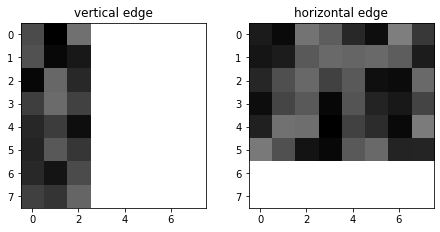

In [3]:
fig = plt.figure(figsize=(32,32))
fig.add_subplot(8,8,1)
plt.gray()
plt.imshow(data_set[979][0].view(8,8))
plt.title('vertical edge')
fig.add_subplot(8,8,2)
plt.imshow(data_set[250][0].view(8,8))
plt.title('horizontal edge')
plt.show()

In [4]:
device = torch.device("cuda")
torch.cuda.empty_cache()
from model1 import generator,discriminator
generator,discriminator = generator.to(device),discriminator.to(device)
print(generator)
print(discriminator)

Generator(
  (embed): Embedding(2, 64)
  (changenoise): Sequential(
    (0): Linear(in_features=100, out_features=32704, bias=True)
    (1): ReLU()
  )
  (model): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Co

Training function:

In [5]:
n_epoch = 25
batch_size = 100
D_optimizer = optim.Adam(discriminator.parameters(), lr=0.002)
G_optimizer = optim.Adam(generator.parameters(), lr=0.002)
dloss = nn.BCELoss()
gloss = nn.BCELoss()

In [6]:
G_loss_list,D_loss_list = [],[]

for epoch in range(n_epoch):
  
  for _,inputs in enumerate(data_loader):

    real_images,label = inputs
    real_images,label = real_images.to(device),label.to(device)

    noise = torch.randn(batch_size,100).to(device)
    fake_target = torch.zeros(batch_size,1).to(device)
    real_target = torch.ones(batch_size,1).to(device)

    D_optimizer.zero_grad()
    xx = discriminator(real_images,label)
    D_real_loss = dloss(xx, real_target)

    generated_image = generator(noise, fake_target.int())
    output = discriminator(generated_image, label)
    D_fake_loss = dloss(output, fake_target)

    # For discriminator:
    D_total_loss = (D_real_loss + D_fake_loss)/2
    D_total_loss = D_total_loss.to(torch.float32)
    D_loss_list.append(D_total_loss)
    D_total_loss.backward(retain_graph=True)
    D_optimizer.step()

    # For generator:
    G_optimizer.zero_grad()
    yy = discriminator(generated_image, label)
    G_loss = gloss(yy, real_target)
    G_loss_list.append(G_loss)
    G_loss.backward()
    G_optimizer.step()

  print('D_loss:',D_total_loss,'G_loss:',G_loss)

D_loss: tensor(0.6736, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(0.7262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss: tensor(0.6580, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(0.7176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss: tensor(0.6448, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(0.7497, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss: tensor(0.6471, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(0.7064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss: tensor(0.6186, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(0.8143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss: tensor(0.6215, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(0.7811, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss: tensor(0.6123, device='cuda:0', grad_fn=<DivBackward0>) G_loss: tensor(0.7799, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D_loss

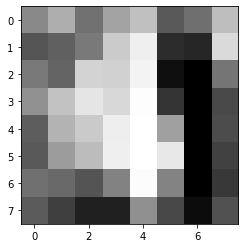

In [16]:
generated_image = generated_image.to("cpu")
plt.imshow(generated_image[88].detach().view(8,8))